In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

#img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))]) 

path = '/content/drive/MyDrive/ml-proyecto-4/'
#path = 'Dataset/'

trainLow_set = torchvision.datasets.ImageFolder(root=path+'dataset_low/train', transform = transform.ToTensor())
trainHigh_set = torchvision.datasets.ImageFolder(root=path+'dataset_high/train', transform = transform.ToTensor())

validLow_set = torchvision.datasets.ImageFolder(root=path+'dataset_low/valid', transform = transform.ToTensor())
validHigh_set = torchvision.datasets.ImageFolder(root=path+'dataset_high/valid', transform = transform.ToTensor())

testLow_set = torchvision.datasets.ImageFolder(root=path+'dataset_low/test', transform = transform.ToTensor())
testHigh_set = torchvision.datasets.ImageFolder(root=path+'dataset_high/test', transform = transform.ToTensor())

#trainLow_set = np.load(path+'train/low_res')
#train_loader = torch.utils.data.DataLoader(dataset=trainLow_set, batch_size=batch_size, shuffle=True)

#img, _ = train_set[0]
img, _ = trainLow_set[0]
print(img.shape)

train_loader = torch.utils.data.DataLoader(dataset=trainLow_set, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=validLow_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=testLow_set, batch_size=batch_size, shuffle=False)


train_h_loader = torch.utils.data.DataLoader(dataset=trainHigh_set, batch_size=batch_size, shuffle=False)
valid_h_loader = torch.utils.data.DataLoader(dataset=validHigh_set, batch_size=batch_size, shuffle=False)
test_h_loader = torch.utils.data.DataLoader(dataset=testHigh_set, batch_size=batch_size, shuffle=False)



cuda:0
torch.Size([3, 256, 256])


In [4]:
# 3 capas
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1) #(256+2*1)= 258-4 =254 -> 254/2+1 = 128
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #(128+2*1)= 130-4 =126 -> 126/2+1 = 64
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) #(64+2*1)= 66-4 =62 -> 62/2+1 = 32
    #self.fc = nn.Linear(in_features=256*32*32, out_features=256)
    self.fc = nn.Linear(in_features=256*32*32, out_features=512)

  def forward(self, image):
    convs = []
    out = F.relu(self.conv1(image))
    convs.append(out)
    out = F.relu(self.conv2(out))
    convs.append(out)
    out = F.relu(self.conv3(out))
    convs.append(out)
    out = out.view(out.size(0), -1)
    z = self.fc(out)
    return z, convs

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.fc = nn.Linear(in_features=512,out_features=256*32*32) 
    #self.fc = nn.Linear(in_features=256,out_features=256*32*32) 
    self.convTran1 = nn.ConvTranspose2d(in_channels=2*256,out_channels=128, kernel_size=4, stride=2, padding=1) #Modificando inchannels. x2 por la copia U-Net
    self.convTran2 = nn.ConvTranspose2d(in_channels=2*128,out_channels=64, kernel_size=4, stride=2, padding=1) #Modificando inchannels. x2 por la copia U-Net
    self.convTran3 = nn.ConvTranspose2d(in_channels=2*64,out_channels=3, kernel_size=4, stride=2, padding=1) #Modificando inchannels. x2 por la copia U-Net
   
  def forward(self, latent,params):
    out = self.fc(latent)
    #out = out.view(out.size(0), 256, 32, 32)

    out = out.view(out.size(0), 256, 32, 32)

    out = torch.cat((params[2],out),1)
    out = F.relu(self.convTran1(out))

    out = torch.cat((params[1],out),1)
    out = torch.tanh(self.convTran2(out))
    
    out = torch.cat((params[0],out),1)
    out = torch.tanh(self.convTran3(out))

    return out


In [5]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent, convs = self.encoder(x)
        x_recon = self.decoder(latent,convs)
        return  x_recon

In [6]:
def train(model, train_loader, Epochs, loss_fn, train_h_loader, valid_loader, valid_h_loader):
    train_loss_avg = []
    valid_loss_avg=[]
    for epoch in range(Epochs):
      #train_loss_avg.append(0)
      #num_batches = 0
      
      # --------------------------------------------- #
      # Error sobre el conjunto de validacion
      iterValidLoader = iter(valid_loader)
      iterValidHighLoader = iter(valid_h_loader)
      
      lossValidList = list()
      for yy in range(len(iterValidLoader)):
        imageVal_batch, _ = next(iterValidLoader)
        imageVal_batch = imageVal_batch.to(device)
        predValid = model(imageVal_batch)
          
        imageVal_h_batch, _ = next(iterValidHighLoader)
        imageVal_h_batch = imageVal_h_batch.to(device)
          
        lossValid = loss_fn(predValid, imageVal_h_batch)
        lossValidList.append(lossValid.item())

      errValidMean = np.mean(lossValidList)
      valid_loss_avg.append(errValidMean) 
      
      # --------------------------------------------- #
      
      #for image_batch, _ in train_loader:
      iterLoader = iter(train_loader)
      iterHighLoader = iter(train_h_loader)

      lossList= list()
      for xx in range(len(iterLoader)):
          image_batch, _ = next(iterLoader)
          image_batch = image_batch.to(device)
          
          image_batch_recon = model(image_batch)

          # Se compara con la imagen de alta definicion
          image_h_batch, _ = next(iterHighLoader)
          image_h_batch = image_h_batch.to(device)

          loss = loss_fn(image_batch_recon, image_h_batch)
          #loss = loss_fn(image_batch_recon, image_batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()          
          lossList.append(loss.item())

      #train_loss_avg[-1] /= num_batches
      train_loss_avg.append(np.mean(lossList))

      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg, valid_loss_avg
    #return train_loss_avg

In [7]:
learning_rate = 0.0015
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()


loss_result, lossVal = train(autoencoder,train_loader,10,loss, train_h_loader, valid_loader, valid_h_loader)
#loss_result, lossVal = train(autoencoder,train_loader,10,loss, train_h_loader, valid_loader, valid_h_loader)


# loss_result, lossVal = train(autoencoder,valid_loader, 60, loss, valid_h_loader, test_loader, test_h_loader)

Epoch [1 / 10] average reconstruction error: 0.137336
Epoch [2 / 10] average reconstruction error: 0.029346
Epoch [3 / 10] average reconstruction error: 0.014699
Epoch [4 / 10] average reconstruction error: 0.008152
Epoch [5 / 10] average reconstruction error: 0.006435
Epoch [6 / 10] average reconstruction error: 0.005372
Epoch [7 / 10] average reconstruction error: 0.004509
Epoch [8 / 10] average reconstruction error: 0.003911
Epoch [9 / 10] average reconstruction error: 0.003482
Epoch [10 / 10] average reconstruction error: 0.003220


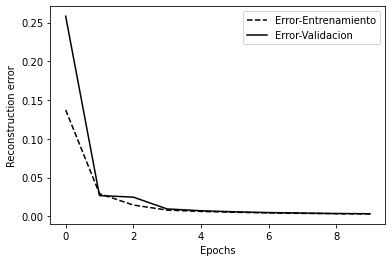

In [8]:
fig = plt.figure()
plt.plot(loss_result,'k--', label='Error-Entrenamiento')
plt.plot(lossVal,'k', label='Error-Validacion')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.legend()
plt.show()

In [9]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

In [ ]:
#Evaluacion de los resultados con el set de TRAIN
autoencoder.eval()

with torch.no_grad():
  image,label = iter(train_loader).next()
  image = image.to(device)
  z,c = autoencoder.encoder(image)

  decodificado = autoencoder.decoder(z,c)
  decodificado = decodificado.to('cpu')

  fig, ax = plt.subplots(figsize=(25, 25))
  Show_Weight(decodificado)
  plt.show()

In [ ]:
#Evaluacion de los resultados con el set de VALIDACION
autoencoder.eval()

with torch.no_grad():
  image,label = iter(valid_loader).next()
  image = image.to(device)
  z,c = autoencoder.encoder(image)
  '''
  z = z.to('cpu')
  mean = z.mean(dim=0)

  std = (z - mean).pow(2).mean(dim=0).sqrt()
  
  z1 = torch.randn(1000, latent_dims)*std + mean
  z1 = z1.to(device)
  '''

  decodificado = autoencoder.decoder(z,c)
  decodificado = decodificado.to('cuda')

  fig, ax = plt.subplots(figsize=(25, 25))
  Show_Weight(decodificado)
  plt.show()

In [ ]:
#Evaluacion de los resultados con el set de TEST
autoencoder.eval()

with torch.no_grad():
  image,label = iter(test_loader).next()
  image = image.to(device)
  z,c = autoencoder.encoder(image)

  decodificado = autoencoder.decoder(z,c)
  decodificado = decodificado.to('cpu')

  fig, ax = plt.subplots(figsize=(25, 25))
  Show_Weight(decodificado)
  plt.show()

In [ ]:
'''
autoencoder.eval()


tensor = torch.zeros(len(test_loader),10)


with torch.no_grad():

  image,label = iter(test_loader).next()
  #image,label = iter(test_loader).next()
  image = image.to(device)
  z,c = autoencoder.encoder(image)
  z = z.to('cpu')
  mean = z.mean(dim=0)

  std = (z - mean).pow(2).mean(dim=0).sqrt()
  
  z1 = torch.randn(1000, latent_dims)*std + mean
  z1 = z1.to(device)
  decodificado = autoencoder.decoder(z1,c)
 
  
 
  decodificado = decodificado.to('cpu')

  fig, ax = plt.subplots(figsize=(25, 25))
  Show_Weight(decodificado[1:1000])
  plt.show()


  '''

"\nautoencoder.eval()\n\n\ntensor = torch.zeros(len(test_loader),10)\n\n\nwith torch.no_grad():\n\n  image,label = iter(test_loader).next()\n  #image,label = iter(test_loader).next()\n  image = image.to(device)\n  z,c = autoencoder.encoder(image)\n  z = z.to('cpu')\n  mean = z.mean(dim=0)\n\n  std = (z - mean).pow(2).mean(dim=0).sqrt()\n  \n  z1 = torch.randn(1000, latent_dims)*std + mean\n  z1 = z1.to(device)\n  decodificado = autoencoder.decoder(z1,c)\n \n  \n \n  decodificado = decodificado.to('cpu')\n\n  fig, ax = plt.subplots(figsize=(25, 25))\n  Show_Weight(decodificado[1:1000])\n  plt.show()\n\n\n  "